# E-ML - Phishing Email Detection with Machine Learning Methods
### By Colin Harrison, Aidan Huerta, and Drew Levy
--- 

In [50]:
print("Importing necessary libraries...\n")
from nltk import word_tokenize
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from sklearn import linear_model
from sklearn import metrics

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

import datasets
import re

import nltk
import sklearn
import numpy as np
from nltk import FreqDist, word_tokenize
from nltk import pos_tag
from typing import List, Tuple, Optional

import warnings
warnings.simplefilter('ignore')

from typing import Any, Dict, Iterable, List, Optional, Set, Tuple

# Might be necessary
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')
print("Done!")

Importing necessary libraries...

Done!


[nltk_data] Downloading package punkt_tab to /home/drewl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/drewl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/drewl/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [51]:
data_df = pd.read_csv('Phishing_Email.csv')
train_size = .8
validation_size = .1
test_size = .1

train_df, temp_df = train_test_split(data_df, train_size = train_size, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=.5, random_state=42)
    
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.expand_frame_rep', False)
print("Training Data shape:", train_df.shape)
print("Validation Data shape:", validation_df.shape)
print("Testing Data shape:", test_df.shape)
print()
print("Below is a small sample of what the data we will be using looks like:")
print(train_df.sample(n=5))

Training Data shape: (14920, 3)
Validation Data shape: (1865, 3)
Testing Data shape: (1865, 3)

Below is a small sample of what the data we will be using looks like:
       Unnamed: 0                                                             Email Text      Email Type
10160       10161  > the number 1 ISP in France and the third ISP in\n> Europe Wanado...      Safe Email
6166         6166  job offering job openings in spoken language application developme...      Safe Email
14188       14189  wellesley list geynille : here is the list of the women who attend...      Safe Email
6995         6996  doorstep meeting sally , following our doorstep meeting today , i ...      Safe Email
3693         3693  time to try gener ! c v ! agra generic sildenafil citrate is the a...  Phishing Email


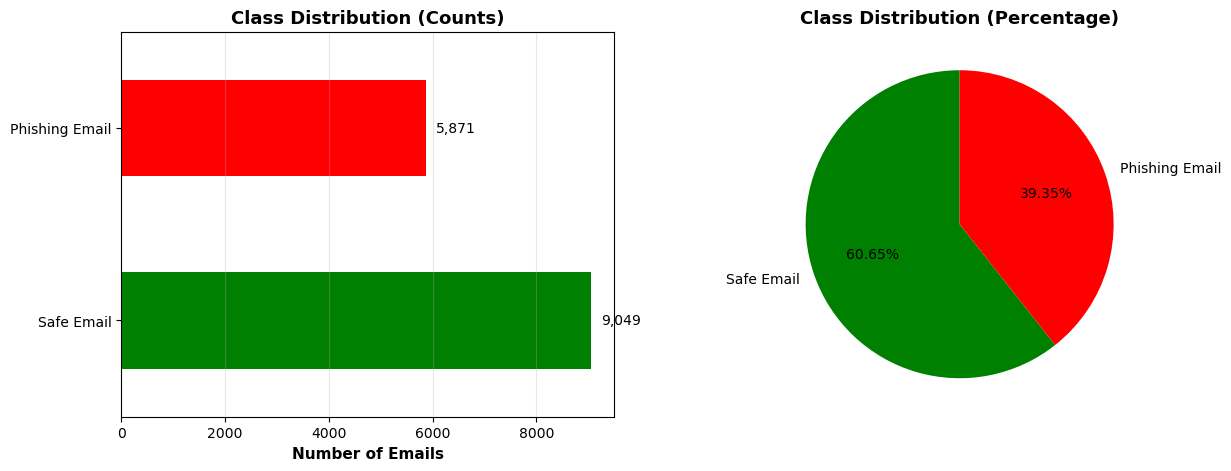

In [33]:
label_cols = ["Email Type"]
counts = train_df[label_cols[0]].value_counts().sort_values(ascending=False)
percentages = (counts / len(train_df)) *100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

colors = ["green", "red"]
counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Number of Emails', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution (Counts)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(counts.items()):
    ax1.text(value + 200, i, f'{value:,}', va='center', fontsize=10)

percentages.plot(kind='pie', ax=ax2, colors=colors, autopct='%1.2f%%', startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=13, fontweight='bold')
ax2.set_ylabel('')
plt.show()

## We know the following
---

In [4]:
for label in counts.index:
    count = counts[label]
    pct = percentages[label]
    ratio = int(len(train_df) / count)
    print(f"{label:<20} {count:>12,} {pct:>11.2f}%")
print(f"{'Total Samples':<20} {len(train_df):>12,}")

Safe Email                  9,049       60.65%
Phishing Email              5,871       39.35%
Total Samples              14,920


### Thus if we can achieve accuracies above this percentages we have learned something about the data

## Preprocessing + Tokenization ##

In [34]:
print("Initializing CountVectorizer (unigrams + bigrams, stopwords removed)...\n")
vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(1,2) )

print("Vectorizing training email text (learning vocabulary)...")
X_train = vectorizer.fit_transform(train_email_text)

print("Vectorizing test email text using learned vocabulary...\n")
X_val = vectorizer.transform(validation_email_text)

print(f"Vocabulary size (number of features): {X_train.shape[1]}")

print("Encoding email labels as binary values (1 = phishing, 0 = safe)\n")
Y_train = (train_df["Email Type"] == "Phishing Email").astype(int)
Y_val = (validation_df["Email Type"] == "Phishing Email").astype(int)


Initializing CountVectorizer (unigrams + bigrams, stopwords removed)...

Vectorizing training email text (learning vocabulary)...
Vectorizing test email text using learned vocabulary...

Number of training examples: 14920
Number of validation examples: 1865
Vocabulary size (number of features): 1445686
Encoding email labels as binary values (1 = phishing, 0 = safe)



## Logistic Regression ##

In [37]:
print("Training Logistic Regression classifier with L2 regularization...\n")
lr_classifier = LogisticRegression(penalty="l2",max_iter=3000,random_state=42)

lr_classifier.fit(X_train, Y_train)

y_pred = lr_classifier.predict(X_val)

y_proba = lr_classifier.predict_proba(X_val)[:, 1]

print("Evaluating model performance on test data...")
print("Validation Accuracy:", accuracy_score(Y_val, y_pred))
print("Validation AUROC:", roc_auc_score(Y_val, y_proba))


Training Logistic Regression classifier with L2 regularization...

Evaluating model performance on test data...
Validation Accuracy: 0.9726541554959786
Validation AUROC: 0.9916834951034679


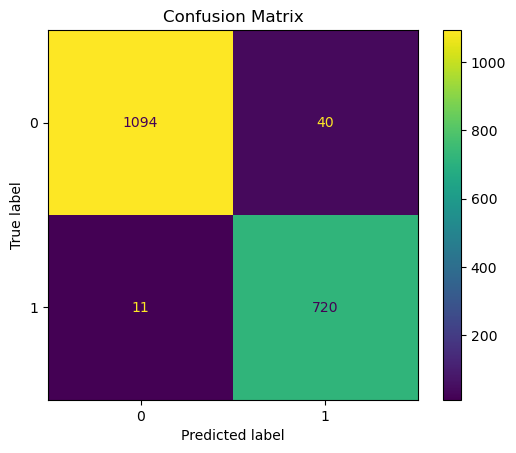

In [56]:
y_pred = lr_classifier.predict(X_val)
c_matrix = confusion_matrix(Y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()
plt.title('Confusion Matrix')
plt.show()

## Discusion:
---
We classify most emails properly, even with this super simple model. We do notice that a majority of the emails we get incorrect are false positives, which could cause disruption when legitimate emails are quarantined. We look to further improve our accuracy with more advanced models.